# HCNN theory

HCNN is a special case of recurrent neural network. Paper "Historical Consistent Complex Valued Recurrent Neural Network" contains detailed description.

**1. Variables:**

* $s_t - \text{hidden state vector of size } (1\times hidden\_dim)$ 
* $W - \text{weight matrix of size } (hidden\_dim\times hidden\_dim)$
* $\hat{y}_t - \text{prediction vector of size } 1\times data\_dim$
* $y_t - \text{target vector of size } 1\times data\_dim$
* $[Id, 0] =[Id_{data\_dim\times data\_dim}, 0_{(hidden\_dim - data\_dim)\times data\_dim}] - \text{transformation matrix from $s_t$ to $\hat{y}_t$ of size }  (data\_dim\times hidden\_dim)$
* $r_t - \text{vector in teacher forcing training of size } 1\times data\_dim$

**2. HCNN equations**

* $s_t = tanh(Ws_{t-1})$, with $s_0$ as random bias

* $\hat{y}_t = [Id, 0]s_t$

**3. Training process uses teacher forcing approach**

* $s_t = tanh(Wr_t)$

* $\hat{y}_t = [Id, 0]s_t$

* $r_t = s_{t} - [Id, 0](\hat{y}_{t} - y_{t})$ 

**4. Loss function**

* $E = \frac{1}{T}\sum_{t=1}^{T} E_t = \frac{1}{T}\sum_{t=1}^{T} (\hat{y}_t - y_t)^2$

* $E_t = (\hat{y}_t - y_t)^2 = \sum_{i=1}^{data\_dim} (\hat{y}_{t,\, i} - y_{t,\, i})$

**5. Backprop**

* $\frac{\partial E}{\partial W} = \sum_{t} \frac{\partial E_t}{\partial W}$

* $\frac{\partial E_t}{\partial W} = \frac{\partial E_t}{\partial \hat{y}_t}\frac{\partial \hat{y}_t}{\partial s_t}\frac{\partial s_t}{\partial W}$


* $\frac{\partial s_t}{\partial W} = \frac{\partial s_t(W,\, r_{t-1}(W,\, s_{t-1}))}{\partial W} = \frac{\partial s_t}{\partial W} + \frac{\partial s_{t}}{\partial r_{t-1}}\frac{\partial r_{t-1}}{\partial W} = \frac{\partial s_t}{\partial W} + \frac{\partial s_{t}}{\partial r_{t-1}}\left( \frac{\partial r_{t-1}}{\partial W} + \frac{\partial r_{t-1}}{\partial s_{t-1}}\frac{\partial s_{t-1}}{\partial W} \right) = \ldots$

* $\frac{\partial E_t}{\partial \hat{y}_t} = 2(\hat{y}_t - y_t)$
* $\frac{\partial \hat{y}_t}{\partial s_t} = [Id, 0]$
* $\frac{\partial s_t}{\partial r_{t-1}} = (1-s_t)^2W$
* $\frac{\partial s_t}{\partial W} = (1-s_t)^2 r_{t-1}$
* $\frac{\partial r_t}{\partial s_t} = 1$

In [0]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from IPython import display
% matplotlib inline

! pip install torch
import torch

# Data generation method

In [0]:
def sample_data(sample_size, signal_freq=60):
  def sine(X, signal_freq=60.):
    return (np.sin(2 * np.pi * (X) / signal_freq) + np.sin(4 * np.pi * (X) / signal_freq)) / 2.0
  
  def noisy(Y, noise_range=(-0.05, 0.05)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    return Y + noise
  
  random_offset = random.randint(0, sample_size)
  X = np.arange(sample_size)
  Y = noisy(sine(X + random_offset, signal_freq))
  return Y

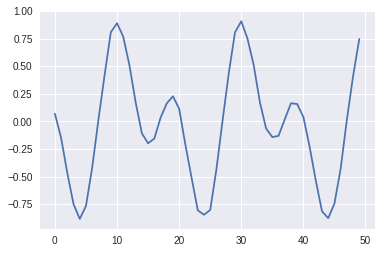

In [0]:
# data = np.array([sample_data(100, 60), sample_data(100, 30)]).T
data = sample_data(50, 20).reshape(-1, 1)
plt.plot(data)

# HCNN in PyTorch

## HCNN Cell

In [0]:
class HCNN_Cell(torch.nn.Module):
  def __init__(self, data_dim, hidden_dim=10):
    super(HCNN_Cell, self).__init__()
    self.W = torch.nn.Linear(hidden_dim, hidden_dim, bias=False)
    self.I = torch.cat((torch.eye(data_dim), torch.zeros(hidden_dim-data_dim, data_dim)), dim=0)
    self.data_dim = data_dim
    self.hidden_dim = hidden_dim        

  def forward(self, s):      
    s = torch.tanh(self.W(s))
    y = torch.mm(self.I.transpose(1, 0), s.view(self.hidden_dim, 1)).view(-1)  # s[t][:data_dim]           
    return y, s

  def init_state(self):
    return torch.randn(self.hidden_dim)

In [0]:
def bptt(hcnn, s, target, opt, criterion):
  target = torch.tensor(data).float()
 
  hcnn.zero_grad()
  loss = 0
  for t in range(len(target)):
    y, s = hcnn.forward(s)
    loss += criterion(y, target[t])
    
    # teacher forcing
    s = s - torch.mm(hcnn.I, (y - target[t]).view(hcnn.data_dim, 1)).view(-1)
 
  loss.backward()
  opt.step()
  return loss.item()/len(target)


def train(hcnn, init_state, target, lr=0.001, epochs=10, verbose=False):
  opt = torch.optim.SGD(hcnn.parameters(), lr=lr)
  criterion = torch.nn.MSELoss()
  
  losses = []
  for i in range(epochs):
    loss = bptt(hcnn, init_state, target, opt, criterion)
    losses.append(loss)
    
    if verbose and (i+1)%25 == 0:  
        fig, ax = plt.subplots(figsize=(15, 4), ncols=2)
        ax[0].plot(np.arange(1, i+2), np.array(losses), 'grey')
        ax[0].set_xlabel('epoch'), ax[0].set_ylabel('loss'), ax[0].set_title(f'Traning loss on epoch {i+1}: {loss}')
        
        pred = sample(hcnn, init_state, int(len(data)*1.5))
        colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
        for c in range(data.shape[1]):
          ax[1].plot(pred[:, c], '--', label=f'model {c+1}', color=colors[c], alpha=1)
          ax[1].plot(data[:, c], label=f'actual {c+1}', color=colors[c], alpha=0.3)
        ax[1].set_title(f'predict (start from 0), epoch: {i+1}')
        legend_pred = ax[1].legend(frameon=True, loc='upper right')
        legend_pred.get_frame().set_color('white')
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.tight_layout()
        plt.close()
        
  return np.array(losses)


def sample(hcnn, state, n=10):
  sample = []
  s = state.clone()
  for t in range(n):
    y, s = hcnn(s)
    sample.append(y.detach().numpy())
    
  return np.array(sample)

### Build HCNN model (Example)

In [0]:
data_dim = data.shape[1]
hidden_dim = 30

hcnn_cell = HCNN_Cell(data_dim=data_dim, hidden_dim=hidden_dim)
init_state = hcnn_cell.init_state()

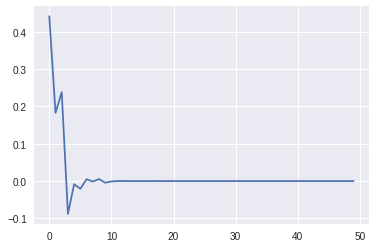

In [0]:
# how sample looks without training 
plt.plot(sample(hcnn_cell, init_state, n=50))

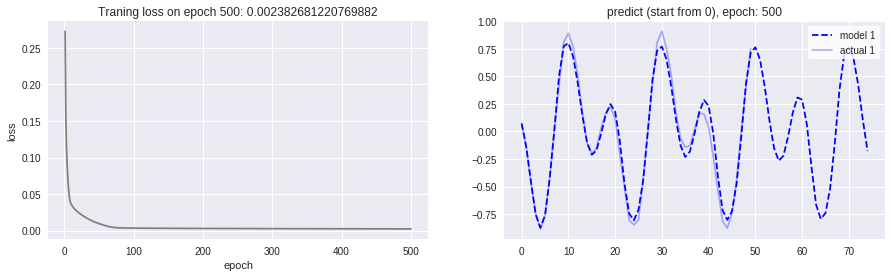

In [0]:
train_loss = train(hcnn_cell, init_state, data, lr=0.01, epochs=500, verbose=True)

# PLOT TRAIN LOSS
# plt.plot(range(1, len(train_loss)+1), train_loss)
# plt.xlabel('epoch'), plt.ylabel('loss'), plt.title('Traning loss (mse)'), plt.show()

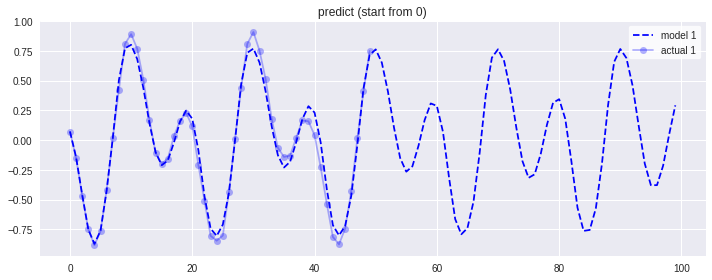

In [0]:
# PLOT FORECAST
fig, ax = plt.subplots(figsize=(10, 4))

pred = sample(hcnn_cell, init_state, int(len(data)*2.0))
colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
for c in range(data.shape[1]):
    ax.plot(pred[:, c], '--', label=f'model {c+1}', color=colors[c], alpha=1)
    ax.plot(data[:, c], 'o-', label=f'actual {c+1}', color=colors[c], alpha=0.3)
ax.set_title(f'predict (start from 0)')
legend_pred = ax.legend(frameon=True, loc='upper right')
legend_pred.get_frame().set_color('white')
plt.tight_layout()

## HCNN wrapped in class (learn initial hidden state as an option)

In [0]:
class HCNNCell(torch.nn.Module):
    def __init__(self, data_dim, hidden_dim=10, init_state_trainable=True, dropout=0, sparsity=0, weight_std=0.1, weight_minmax_norm=None):
      super(HCNNCell, self).__init__()      
      
      self.init_state = None
      if init_state_trainable:
        self.init_state = torch.nn.Parameter(torch.randn(hidden_dim), requires_grad=True)
        torch.nn.init.normal_(self.init_state, std=weight_std)
      
      self.W = torch.nn.Linear(hidden_dim, hidden_dim, bias=False)
      torch.nn.init.sparse_(self.W.weight, sparsity=sparsity, std=weight_std) # https://pytorch.org/docs/0.3.1/nn.html#torch.nn.init.sparse
      
      if weight_minmax_norm is not None:
        self.W.weight.data = min_max_norm(self.W.weight.data, (-weight_minmax_norm, weight_minmax_norm))
        if self.init_state is not None:
          self.init_state.weight.data = min_max_norm(self.init_state.weight.data, (-weight_minmax_norm, weight_minmax_norm))
      
      self.dropout = torch.nn.Dropout(dropout)
      self.I = torch.cat((torch.eye(data_dim), torch.zeros(hidden_dim-data_dim, data_dim)), dim=0)
      self.data_dim = data_dim
      self.hidden_dim = hidden_dim        
    
    def forward(self, s):      
      s = torch.tanh(self.dropout(self.W(s)))
      y = torch.mm(self.I.transpose(1, 0), s.view(self.hidden_dim, 1)).view(-1)  # s[t][:data_dim]           
      return y, s
    
    
    def init_state_(self, bias_std=0.1, bias_minmax_norm=None):
      bias = torch.randn(self.hidden_dim) * bias_std
      if bias_minmax_norm is not None:
        bias = min_max_norm(bias, (-bias_minmax_norm, bias_minmax_norm))
      return bias


class HCNN:
  def __init__(self, data_dim, hidden_dim=10, init_state_trainable=True, dropout=0, sparsity=0, weight_std=0.1, weight_minmax_norm=None):    
    self.hcnn = HCNNCell(
        data_dim=data_dim, 
        hidden_dim=hidden_dim, 
        init_state_trainable=init_state_trainable,
        dropout=dropout,
        sparsity=sparsity,
        weight_std=weight_std,
        weight_minmax_norm=weight_minmax_norm
    )
    
  
  def init_state(self, bias_std=0.1, bias_minmax_norm=None):
    return self.hcnn.init_state_(bias_std, bias_minmax_norm)
  
  
  @staticmethod 
  def bptt(hcnn: HCNNCell, state, data, opt, criterion):
    data = torch.tensor(data.copy()).float()

    hcnn.zero_grad()
    s = state
    loss = 0
    for t in range(len(data)):
      y, s = hcnn.forward(s)
      loss += criterion(y, data[t])
      s = s - torch.mm(hcnn.I, (y - data[t]).view(hcnn.data_dim, 1)).view(-1)

    loss.backward()
    opt.step()
    return loss.item()/len(data)
  
  
  def train(self, data, state=None, lr=0.001, epochs=10, criterion=torch.nn.MSELoss(), verbose=False, plot_loss=False, plot_pred_train=False):      
    opt=torch.optim.Adam(self.hcnn.parameters(), lr=lr)
    # criterion = LogCosh.apply  # torch.nn.MSELoss() # + self.hcnn.W.weight.abs().sum()
    
    state = self.hcnn.init_state if state is None else state.clone()
      
    losses = []
    for i in range(epochs):
      loss = self.bptt(self.hcnn, state, data, opt, criterion)
      losses.append(loss)      
      
      if verbose:
        print(f'Train epoch {i+1}/{epochs}, loss: {loss}')
        # print('W'), print(self.hcnn.W.weight.data)
        print()
        print('init_state')
        print(state)
        
      if plot_loss and (i+1)%25 == 0:
        fig, ax = plt.subplots()
        ax.plot(np.arange(1, i+2), np.array(losses), 'grey')
        ax.set_xlabel('epoch'), ax.set_ylabel('loss'), ax.set_title(f'Traning loss on epoch {i+1}: {loss}')
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.tight_layout()
        plt.close()
        
      if plot_pred_train and (i+1)%25 == 0:  
        fig, ax = plt.subplots(figsize=(15, 4), ncols=2)
        ax[0].plot(np.arange(1, i+2), np.array(losses), 'grey')
        ax[0].set_xlabel('epoch'), ax[0].set_ylabel('loss'), ax[0].set_title(f'Traning loss on epoch {i+1}: {loss}')
        
        pred = self.sample(state, int(len(data)*1.5))
        colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
        for c in range(data.shape[1]):
          ax[1].plot(pred[:, c], '--', label=f'model {c+1}', color=colors[c], alpha=1)
          ax[1].plot(data[:, c], label=f'actual {c+1}', color=colors[c], alpha=0.3)
        ax[1].set_title(f'predict (start from 0), epoch: {i+1}')
        legend_pred = ax[1].legend(frameon=True, loc='upper right')
        legend_pred.get_frame().set_color('white')
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.tight_layout()
        plt.close()
    
    return np.array(losses)
  
  
  def forward(self, state, n):
    s = state.clone()
    for t in range(n):
      y, s = self.hcnn.forward(s)
    return s   
  
  
  def sample(self, state, n=10):
    sample = []
    s = state.clone()
    for t in range(n):
      y, s = self.hcnn(s)
      sample.append(y.detach().numpy())

    return np.array(sample)

### LogCosh loss

In [0]:
class LogCosh(torch.autograd.Function):  
    @staticmethod
    def forward(ctx, y_pred, y):
        ctx.save_for_backward(y_pred, y)
        return torch.log(torch.cosh(y_pred - y)).sum()

    @staticmethod
    def backward(ctx, grad_output):
        yy_pred, yy = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input = torch.tanh(yy_pred - yy)
        return grad_input, None

### Build HCNN without learning of init_state

In [0]:
hcnn = HCNN(data_dim=data.shape[1], hidden_dim=30, init_state_trainable=False)
init_state = hcnn.init_state()

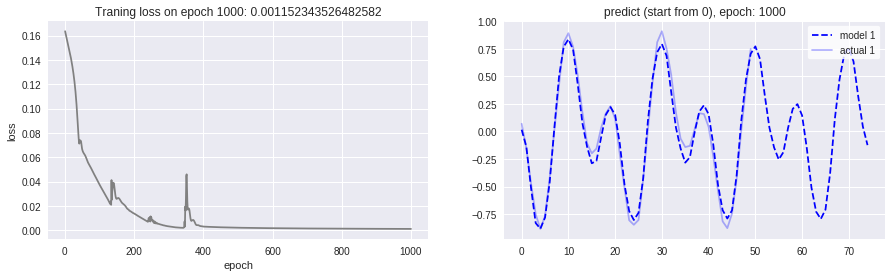

In [0]:
train_loss = hcnn.train(data, init_state, lr=0.001, epochs=1000, criterion=LogCosh.apply, plot_pred_train=True)  # criterion=torch.nn.MSELoss() or criterion=LogCosh.apply

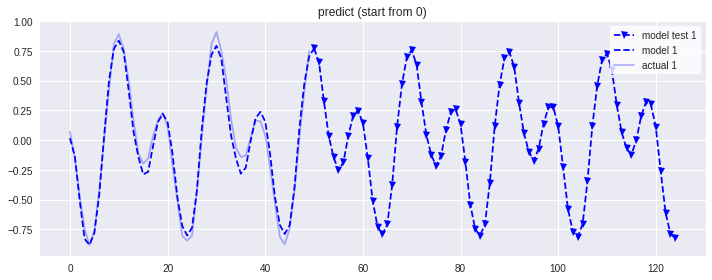

In [0]:
fig, ax = plt.subplots(figsize=(10, 4))

pred = hcnn.sample(init_state, int(len(data))+1)
pred_test = hcnn.sample(hcnn.forward(init_state, len(data)), int(len(data)*1.5))
colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
for c in range(data.shape[1]):
  ax.plot(np.arange(pred_test.shape[0]) + data.shape[0], pred_test[:, c], 'v--', label=f'model test {c+1}', color=colors[c], alpha=1)
  ax.plot(pred[:, c], '--', label=f'model {c+1}', color=colors[c], alpha=1)
  ax.plot(data[:, c], label=f'actual {c+1}', color=colors[c], alpha=0.3)
ax.set_title(f'predict (start from 0)')
legend_pred = ax.legend(frameon=True, loc='upper right')
legend_pred.get_frame().set_color('white')
plt.tight_layout()

### Build HCNN with learning of init_state

In [0]:
hcnn = HCNN(data_dim=data.shape[1], hidden_dim=30, init_state_trainable=True)

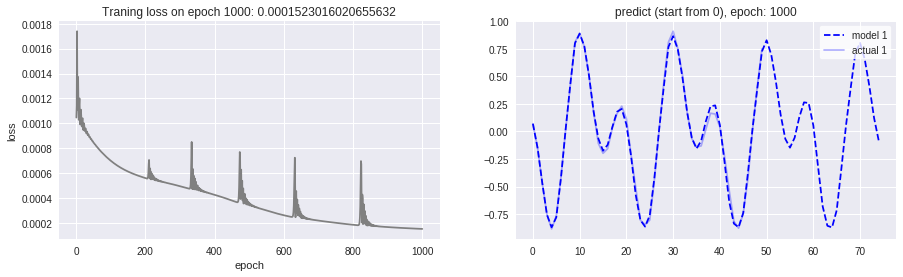

In [0]:
train_loss = hcnn.train(data, state=None, lr=0.001, epochs=1000, criterion=LogCosh.apply, plot_loss=False, plot_pred_train=True, verbose=False)  # criterion=torch.nn.MSELoss() or criterion=LogCosh.apply

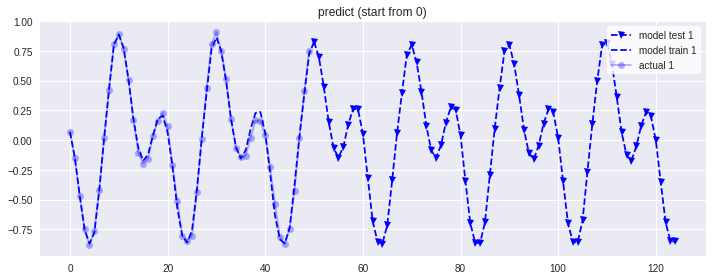

In [0]:
fig, ax = plt.subplots(figsize=(10, 4))

pred = hcnn.sample(hcnn.hcnn.init_state, int(len(data))+1)
pred_test = hcnn.sample(hcnn.forward(hcnn.hcnn.init_state, len(data)), int(len(data)*1.5))
colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
for c in range(data.shape[1]):
  ax.plot(np.arange(pred_test.shape[0]) + data.shape[0], pred_test[:, c], 'v--', label=f'model test {c+1}', color=colors[c], alpha=1)
  ax.plot(pred[:, c], '--', label=f'model train {c+1}', color=colors[c], alpha=1)
  ax.plot(data[:, c], 'o-', label=f'actual {c+1}', color=colors[c], alpha=0.3)
ax.set_title(f'predict (start from 0)')
legend_pred = ax.legend(frameon=True, loc='upper right')
legend_pred.get_frame().set_color('white')
plt.tight_layout()